# Lecture : Graph Generation Models

## Lab 04 : Wasserstein generative adversarial networks (WGAN) for QM9 molecular graphs

### Xavier Bresson


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd 
    

In [2]:
# Libraries
import os
import time
from rdkit import Chem
from rdkit import RDLogger; RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import Draw
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
import sys; sys.path.insert(0, 'lib/')
from lib.molecules import Dictionary, Molecule, from_pymol_to_smile

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:1") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda:1


## Loading molecular datasets (PyTorch format)

Loading data...
dataset/QM9_1.4k_pytorch/
Time: 0.531672477722168
num train data : 1000
atom_dict.idx2word : ['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -']
atom_dict.word2idx : {'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
9 4
train[idx].atom_type : tensor([1, 1, 2, 1, 1, 1, 1])
train[idx].atom_type_pe : tensor([0, 1, 0, 2, 3, 4, 5])
train[idx].bond_type : tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
train[idx].bag_of_atoms : tensor([0, 6, 1, 0, 0, 0, 0, 0, 0])
train[idx].smile:  CC(O)C1CC1C


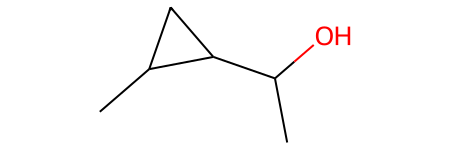

In [3]:
print('Loading data...') 
start = time.time()

data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print('num train data :',len(train)) 

print('atom_dict.idx2word :',atom_dict.idx2word)
print('atom_dict.word2idx :',atom_dict.word2idx)
print('bond_dict.idx2word :',bond_dict.idx2word)
print('bond_dict.word2idx :',bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print('train[idx].atom_type :',train[idx].atom_type)
print('train[idx].atom_type_pe :',train[idx].atom_type_pe)
print('train[idx].bond_type :',train[idx].bond_type)
print('train[idx].bag_of_atoms :',train[idx].bag_of_atoms)
print('train[idx].smile: ',train[idx].smile)
mol = Chem.MolFromSmiles(train[idx].smile)
mol


## Print dataset statistics

In [4]:
# Organize data into group of of molecules of fixed sized
# Example: train[9] is a list containing all the molecules of size 9  
def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict
test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[8])) # QM9

# largest size of molecule in the trainset
max_mol_sz = max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)

# print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try: 
            print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
        except:
            pass
print('Train'); print_distribution(train_group)
print('Val'); print_distribution(val_group)
print('Test'); print_distribution(test_group)


136
Max num atoms =  9
Train
number of molecule of size 4: 	 1
number of molecule of size 5: 	 1
number of molecule of size 6: 	 7
number of molecule of size 7: 	 24
number of molecule of size 8: 	 136
number of molecule of size 9: 	 831
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


## Generate batch of pytorch molecules of same size

In [5]:
# A class to help drawing batches of molecules with the same size
class MoleculeSampler:
    def __init__(self, organized_dataset, bs , shuffle=True):  
        self.bs = bs
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.counter = { sz: 0   for sz in organized_dataset }
        if shuffle:
            self.order = { sz: np.random.permutation(num)  for sz , num in self.num_mol.items() }
        else:
            self.order = { sz: np.arange(num)  for sz , num in self.num_mol.items() } 

    def compute_num_batches_remaining(self):
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol} 

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum( num_batches.values() ) == 0

    def draw_batch_of_molecules(self, sz):  
        num_batches = self.compute_num_batches_remaining()
        if (self.num_mol[sz] - self.counter[sz])/self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz]//self.bs) * self.bs
        #print('sz, bs',sz, bs)
        indices = self.order[sz][ self.counter[sz] : self.counter[sz] + bs]
        self.counter[sz] += bs 
        return indices

# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
while(not sampler.is_empty()):
    num_batches_remaining = sampler.compute_num_batches_remaining()
    print('num_batches_remaining :',num_batches_remaining)
    sz = sampler.choose_molecule_size()
    print('sz :',sz)
    indices = sampler.draw_batch_of_molecules(sz) 
    print('indices :',len(indices),indices)
    minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] )
    print('minibatch_node :',minibatch_node.size())
    minibatch_pe  = torch.stack( [ train_group[sz][i].atom_type_pe  for i in indices] )
    print('minibatch_pe :',minibatch_pe.size())
    minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] )
    print('minibatch_edge :',minibatch_edge.size())
    minibatch_boa = torch.stack( [ train_group[sz][i].bag_of_atoms for i in indices] )
    print('minibatch_boa :',minibatch_boa.size())
    break
    print('---------------------------------------')


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 9
indices : 50 [219 692 776 386 657 565 364 123 653 635 321 751 598 342 327 507 616  60
 284 521 375   0 142 202 238 686 513 194 652 502 572 558 740 282  28 520
 628 640 164 650 376 456 633 319 278 451 765 667  76 103]
minibatch_node : torch.Size([50, 9])
minibatch_pe : torch.Size([50, 9])
minibatch_edge : torch.Size([50, 9, 9])
minibatch_boa : torch.Size([50, 9])


## Sample molecule size

In [6]:
# A class to sample a molecule size w.r.t. the train distribution
class sample_molecule_size:
    def __init__(self, organized_dataset):  
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.num_batches_remaining = { sz:  self.num_mol[sz]  for sz in self.num_mol } 
    def choose_molecule_size(self):
        num_batches = self.num_batches_remaining
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz
        
sampler_size = sample_molecule_size(train_group)
print('sampler_size.num_mol :',sampler_size.num_mol)
sz = sampler_size.choose_molecule_size()
print('sz :',sz)


sampler_size.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
sz : 9


# WGAN [1,2,3] with Graph Transformers [4] 

[1] Goodfellow et-al, Generative Adversarial Networks, 2014, https://arxiv.org/pdf/1406.2661  
[2] Arjovsky et-al, Wasserstein GAN, 2017, https://arxiv.org/pdf/1701.07875  
[3] Gulrajani et-al, Improved Training of Wasserstein GANs, 2017, https://arxiv.org/pdf/1704.00028  
[4] Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020, https://arxiv.org/pdf/2012.09699.pdf  


In [7]:
# Global constants
dz = 16 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_discriminator = 2 # number of transformer discrimator layers
num_layers_generator = 4 # number of transformer generator layers
drop = 0.0 # dropout value
dropout_discrimator = 0.05 # dropout value for discrimator
bs = 25 # batch size

dz = 16; num_heads = 4; d = 32 * num_heads; num_layers_discriminator = 2; num_layers_generator = 4; dropout_discrimator = 0.05; bs = 25 # v1
# dz = 16; num_heads = 4; d = 32 * num_heads; num_layers_discriminator = 2; num_layers_generator = 6; dropout_discrimator = 0.05; bs = 25 # v2

print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, dropout_discrimator, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, dropout_discrimator, bs)
 
# Warmup 
num_mol_size = 20
num_warmup = 2 * max( num_mol_size, len(train) // bs ) # 4 epochs * max( num_mol_size=20, num_mol/batch_size)
print('num_warmup :',num_warmup)


dz, num_heads, d, num_layers_discriminator, num_layers_generator, dropout_discrimator, bs :  16 4 128 2 4 0.05 25
num_warmup : 80


In [8]:
# Define WGAN architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)
    def forward(self, x, e):
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E              # [bs, n, n, d_head]
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)            # [bs, n, n]
        Att = self.drop_att(Att)                   # [bs, n, n]
        x = Att @ V                                # [bs, n, d_head]
        return x, e                  # [bs, n, d_head], [bs, n, n, d_head]

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
        self.drop_e = nn.Dropout(drop)
    def forward(self, x, e):
        x_MHA = []
        e_MHA = []    
        for head in self.heads:
            x_HA, e_HA = head(x,e)            # [bs, n, d_head], [bs, n, n, d_head]
            x_MHA.append(x_HA)
            e_MHA.append(e_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)                    # [bs, n, n, d]
        return x, e                           # [bs, n, d], [bs, n, n, d]

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNe = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.LNe2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.MLPe = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.drop_e_mlp = nn.Dropout(drop)
    def forward(self, x, e):
        x = self.LNx(x)                 # [bs, n, d]
        e = self.LNe(e)                 # [bs, n, n, d]
        x_MHA, e_MHA = self.MHA(x, e)   # [bs, n, d], [bs, n, n, d]
        x = x + x_MHA                   # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        e = e + e_MHA                   # [bs, n, n, d]
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]
        e = self.drop_e_mlp(e)          # [bs, n, n, d]
        return x, e                     # [bs, n, d], [bs, n, n, d]

def sym_tensor(x):
    x = x.permute(0,3,1,2) # [bs, d, n, n]
    triu = torch.triu(x,diagonal=1).transpose(3,2) # [bs, d, n, n]
    mask = (triu.abs()>0).float()                  # [bs, d, n, n]
    x =  x * (1 - mask ) + mask * triu             # [bs, d, n, n]
    x = x.permute(0,2,3,1) # [bs, n, n, d]
    return x               # [bs, n, n, d]

class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_z_h = nn.Linear(dz, d)
        self.ln_h = nn.LayerNorm(d)
        self.ln_e = nn.LayerNorm(d)
        self.linear_h = nn.Linear(d, d)
        self.linear_e = nn.Linear(d, d)
        self.gt_gen_layers = nn.ModuleList( [BlockGT(d, num_heads) for k in range(num_layers_generator)] ) 
        self.ln_final_h = nn.LayerNorm(d)  
        self.ln_final_e = nn.LayerNorm(d)  
        self.linear_final_h = nn.Linear(d, num_atom_type)
        self.linear_final_e = nn.Linear(d, num_bond_type)
    def forward(self, z, pe, n):          
        # input layer
        z = self.linear_z_h(z)           # [bs, d] 
        h = z.unsqueeze(1).repeat(1,n,1) # [bs, 1, d] => [bs, n, d]
        h = h + pe                       # [bs, n, d]
        e = z.unsqueeze(1).unsqueeze(2).repeat(1,n,n,1) # [bs, 1, 1, d] => [bs, n, n, d] 
        e = e + pe.unsqueeze(1) + pe.unsqueeze(2)       # [bs, n, n, d]  
        e = sym_tensor(e)     # [bs, n, n, d] 
        h = self.ln_h(h)      # [bs, n, d]
        e = self.ln_e(e)      # [bs, n, n, d] 
        h = nn.LeakyReLU()(h) # [bs, n, d] 
        e = nn.LeakyReLU()(e) # [bs, n, n, d] 
        h = self.linear_h(h)  # [bs, n, d]
        e = self.linear_e(e)  # [bs, n, n, d]
        # L layers
        for gt_gen_layer in self.gt_gen_layers:  
            h, e = gt_gen_layer(h, e) # [bs, n, d],  [bs, n, n, d]
            e = sym_tensor(e)         # [bs, n, n, d]
        # output    
        h = nn.LeakyReLU()(h)  # [bs, n, d] 
        e = nn.LeakyReLU()(e)  # [bs, n, n, d] 
        h = self.ln_final_h(h) # [bs, n, d] 
        e = self.ln_final_e(e) # [bs, n, n, d] 
        h = self.linear_final_h(h) # [bs, n, num_atom_type]
        e = self.linear_final_e(e) # [bs, n, n, num_bond_type] 
        return h, e

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.atom_emb = nn.Linear(num_atom_type, d)
        self.bond_emb = nn.Linear(num_bond_type, d)
        self.gt_dis_layers = nn.ModuleList( [BlockGT(d, num_heads) for k in range(num_layers_discriminator)] )  
        self.dp_h_dis_layers = nn.ModuleList( [nn.Dropout(p=dropout_discrimator) for k in range(num_layers_discriminator)] )  
        self.dp_e_dis_layers = nn.ModuleList( [nn.Dropout(p=dropout_discrimator) for k in range(num_layers_discriminator)] )  
        self.linear_out = nn.Linear(d, 1)
    def forward(self, h, e, pe): 
        # input layer
        h = self.atom_emb(h)                   # [bs, n, d]
        h = h + pe                             # [bs, n, d]
        e = self.bond_emb(e)                   # [bs, n, n, d]
        e = e + pe.unsqueeze(1) + pe.unsqueeze(2) # [bs, n, n, d]  
        e = sym_tensor(e)                      # [bs, n, n, d]
        # L layers
        for k in range(num_layers_discriminator): 
            h, e = self.gt_dis_layers[k](h, e) # [bs, n, d], [bs, n, n, d]
            h = self.dp_h_dis_layers[k](h)     # [bs, n, d]
            e = self.dp_e_dis_layers[k](e)     # [bs, n, n, d]
        # output  
        mol_token = h.mean(1)           # [bs, d] molecule token  
        h = self.linear_out(mol_token)  # [bs, 1]
        return h

class WGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(max_mol_sz, d)
        self.generator = generator()
        self.discriminator = discriminator()
    def forward_gen(self, z, n):
        bs2 = z.size(0)
        pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
        pe_x = self.pe_x(pe_x)                            # [bs, n, d] 
        h, e = self.generator(z, pe_x, n)                 # [bs, n, num_atom_type], [bs, n, n, num_bond_type] 
        return h, e
    def forward_dis(self, h, e, n):
        bs2 = h.size(0)
        pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
        pe_x = self.pe_x(pe_x)                            # [bs, n, d] 
        d_h = self.discriminator(h, e, pe_x)              # [bs, 1]
        return d_h


try:
    del net
    torch.cuda.empty_cache()
except:
  print("First run")


# Instantiate the network
net = WGAN()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.001
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr)
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr)

sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz',sz)
indices = sampler.draw_batch_of_molecules(sz) 
#print('indices :',len(indices),indices)
x_real = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
x_real = torch.nn.functional.one_hot(x_real, num_atom_type).float() # [bs, n, num_atom_type] one hot encoding
print('x_real',x_real.size())
e_real = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
e_real = torch.nn.functional.one_hot(e_real, num_bond_type).float() # [bs, n, num_bond_type] one hot encoding 
print('e_real',e_real.size())

bs2 = x_real.size(0)
z = torch.rand(bs2, dz).to(device) # [bs, dz]
print('z',z.size())
x_fake, e_fake = net.forward_gen(z, sz) # [bs, n]
print('x_fake, e_fake',x_fake.size(), e_fake.size())

fake_discr = net.forward_dis(x_fake, e_fake, sz) # [bs, 1]    
print('fake_discr',fake_discr.size())
real_discr = net.forward_dis(x_real, e_real, sz) # [bs, 1]
print('real_discr',real_discr.size())
loss = fake_discr.mean() - real_discr.mean()

epsilon = torch.FloatTensor(bs2, 1, 1).uniform_(0, 1).to(device)
x_hat = epsilon * x_fake + (1 - epsilon) * x_real
epsilon = torch.FloatTensor(bs2, 1, 1, 1).uniform_(0, 1).to(device)
e_hat = epsilon * e_fake + (1 - epsilon) * e_real
print('x_hat',x_hat.size())
print('e_hat',e_hat.size())
xhat_discr = net.forward_dis(x_hat, e_hat, sz)
grad_x, grad_e = torch.autograd.grad(xhat_discr, [x_hat, e_hat], grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[:2]
penalty = ((torch.sqrt((grad_x ** 2).sum([1,2])) - 1) ** 2).mean()
penalty += ((torch.sqrt((grad_e ** 2).sum([1,2,3])) - 1) ** 2).mean()
loss = loss + 10 * penalty

optimizer_d.zero_grad()
loss.backward()
optimizer_d.step()

z = torch.rand(bs, dz).to(device) # [bs, dz]
x_gen, e_gen = net.forward_gen(z, sz)
loss = - net.forward_dis(x_gen, e_gen, sz).mean()
optimizer_g.zero_grad()
loss.backward()
optimizer_g.step()

# generate new data
with torch.no_grad():
    num_data = 4; num_atom = 9
    z = torch.rand(num_data, dz).to(device)     # [bs, dz]
    x_gen, e_gen = net.forward_gen(z, num_atom) # [bs, n, num_atom_type], [bs, n, num_bond_type]
    x_gen = torch.max(x_gen, dim=2)[1]          # [bs, n]
    e_gen = torch.max(e_gen, dim=3)[1]          # [bs, n, n]
    print('x_gen',x_gen.size())
    print('e_gen',e_gen.size())



First run
Number of parameters: 2420366 (2.42 million)
sampler.num_mol {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining {9: 34, 8: 6, 7: 1, 6: 1, 5: 1, 4: 1}
sz 9
x_real torch.Size([25, 9, 9])
e_real torch.Size([25, 9, 9, 4])
z torch.Size([25, 16])
x_fake, e_fake torch.Size([25, 9, 9]) torch.Size([25, 9, 9, 4])
fake_discr torch.Size([25, 1])
real_discr torch.Size([25, 1])
x_hat torch.Size([25, 9, 9])
e_hat torch.Size([25, 9, 9, 4])
x_gen torch.Size([4, 9])
e_gen torch.Size([4, 9, 9])


In [9]:
# Training loop
del net
net = WGAN()
net = net.to(device)
_ = display_num_param(net)   

# Optimizer
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.0003
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr, betas=(0.0, 0.9))
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr, betas=(0.0, 0.9))
scheduler_d = optim.lr_scheduler.ReduceLROnPlateau(optimizer_d, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 1000
run_every_k_steps = 5
print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, dropout_discrimator, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, dropout_discrimator, bs)
print('num_warmup, nb_epochs :',num_warmup, nb_epochs)

start = time.time()
for epoch in range(nb_epochs):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0

    net.train()

    sampler = MoleculeSampler(train_group, bs)
    count = 0
    while(not sampler.is_empty()):
        
        # discriminator update
        sz = sampler.choose_molecule_size()
        idx_real = sampler.draw_batch_of_molecules(sz) 
        x_real = torch.stack( [ train_group[sz][i].atom_type for i in idx_real] ).long().to(device) # [bs, n]
        x_real = torch.nn.functional.one_hot(x_real, num_atom_type).float() # [bs, n, num_atom_type] one hot encoding
        e_real = torch.stack( [ train_group[sz][i].bond_type for i in idx_real] ).long().to(device) # [bs, n, n]
        e_real = torch.nn.functional.one_hot(e_real, num_bond_type).float() # [bs, n, num_bond_type] one hot encoding 
        bs2 = x_real.size(0)
        z = torch.rand(bs2, dz).to(device) # [bs, dz]
        x_fake, e_fake = net.forward_gen(z, sz) # [bs, n]
        fake_discr = net.forward_dis(x_fake, e_fake, sz) # [bs, 1]  
        real_discr = net.forward_dis(x_real, e_real, sz) # [bs, 1]
        loss = fake_discr.mean() - real_discr.mean()
        epsilon = torch.FloatTensor(bs2, 1, 1).uniform_(0, 1).to(device)
        x_hat = epsilon * x_fake + (1 - epsilon) * x_real
        epsilon = torch.FloatTensor(bs2, 1, 1, 1).uniform_(0, 1).to(device)
        e_hat = epsilon * e_fake + (1 - epsilon) * e_real
        xhat_discr = net.forward_dis(x_hat, e_hat, sz)
        grad_x, grad_e = torch.autograd.grad(xhat_discr, [x_hat, e_hat], grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[:2]
        penalty = ((torch.sqrt((grad_x ** 2).sum([1,2])) - 1) ** 2).mean()
        penalty += ((torch.sqrt((grad_e ** 2).sum([1,2,3])) - 1) ** 2).mean()
        loss = loss + 1 * penalty
        running_loss_d = -loss.detach().cpu().item() 
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # generator update
        if count % run_every_k_steps == 0:
            z = torch.rand(bs, dz).to(device) # [bs, dz]
            x_gen, e_gen = net.forward_gen(z, sz)
            loss = - net.forward_dis(x_gen, e_gen, sz).mean()
            optimizer_g.zero_grad()
            loss.backward()
            optimizer_g.step()     
        running_loss_g += loss.detach().cpu().item()      

        # Compute stats
        count += 1
        num_batches += 1 # stats
        
    # Average stats
    mean_loss_d = running_loss_d/ num_batches 
    mean_loss_g = running_loss_g/ num_batches
    if epoch>25:
        scheduler_d.step(mean_loss_d)
        optimizer_g.param_groups[0]['lr'] = optimizer_d.param_groups[0]['lr']
    elapsed = (time.time()-start)/60    
    if not epoch%5:
        print('epoch= %d \t time= %.4f min \t lr_d= %.7f \t lr_g= %.7f \t loss_d= %.4f \t loss_g= %.4f' % (epoch, elapsed, optimizer_d.param_groups[0]['lr'], optimizer_g.param_groups[0]['lr'], mean_loss_d, mean_loss_g) )

    # Check lr value
    if optimizer_d.param_groups[0]['lr'] < 10**-6: 
      print("\n lr is equal to min lr -- training stopped\n")
      break   
        


Number of parameters: 2420366 (2.42 million)
dz, num_heads, d, num_layers_discriminator, num_layers_generator, dropout_discrimator, bs :  16 4 128 2 4 0.05 25
num_warmup, nb_epochs : 80 1000


/home/deeplearn/miniconda3/envs/gnn_course_gpu/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch= 0 	 time= 0.0799 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.0067 	 loss_g= 0.8328
epoch= 5 	 time= 0.4851 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.0827 	 loss_g= -9.5148
epoch= 10 	 time= 0.8832 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.1451 	 loss_g= -10.5602
epoch= 15 	 time= 1.2798 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.1237 	 loss_g= -12.4466
epoch= 20 	 time= 1.6767 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.1175 	 loss_g= -10.8298
epoch= 25 	 time= 2.0737 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.1224 	 loss_g= -9.5367
epoch= 30 	 time= 2.4719 min 	 lr_d= 0.0002707 	 lr_g= 0.0002707 	 loss_d= 0.0855 	 loss_g= -7.3649
epoch= 35 	 time= 2.8720 min 	 lr_d= 0.0002707 	 lr_g= 0.0002707 	 loss_d= 0.0340 	 loss_g= -9.4458
epoch= 40 	 time= 3.2687 min 	 lr_d= 0.0002444 	 lr_g= 0.0002444 	 loss_d= 0.0839 	 loss_g= -9.3088
epoch= 45 	 time= 3.6659 min 	 lr_d= 0.0002095 	 lr_g= 0.0002095 	 loss_d= 0.0648 	 loss_g= -9.4456


## Compute percentage of valid molecules

In [10]:
# compute percentage of valid molecules
def compute_perc_valid_molecules(net, sampler_size, num_gen_mol=1000, num_generated_mols_per_batch=100):
    num_atom = 9 # QM9
    num_batches = num_gen_mol // num_generated_mols_per_batch 
    num_valid_mol = 0
    list_valid_mol = []
    list_mol = []
    start = time.time()
    for idx in range(num_batches):
        net.eval()
        with torch.no_grad():  
            num_atom_sampled = sampler_size.choose_molecule_size() # sample the molecule size
            num_atom_sampled = num_atom # same size
            z = torch.rand(num_generated_mols_per_batch, dz).to(device) # [bs, dz]
            x_gen, e_gen = net.forward_gen(z, num_atom_sampled) # [bs, n, num_atom_type], [bs, n, num_bond_type]
            batch_x_0 = torch.max(x_gen, dim=2)[1]  # [bs, n]
            batch_e_0 = torch.max(e_gen, dim=3)[1] # [bs, n, n]
            x_hat = batch_x_0.detach().to('cpu')
            e_hat = batch_e_0.detach().to('cpu')
            for x,e in zip(x_hat,e_hat):
                pymol = Molecule(num_atom_sampled, num_atom_type)
                pymol.atom_type = x
                pymol.bond_type = e
                smile = from_pymol_to_smile(pymol, atom_dict, bond_dict)
                list_mol.append(smile)
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    list_valid_mol.append(smile)
                    num_valid_mol += 1
    perc_valid_molecules = 100*num_valid_mol/num_gen_mol
    line = '\t num_gen_mol= ' + str(num_gen_mol) + '   time(min)= ' + str((time.time()-start)/60)[:5] + '   perc valid molecules= ' + str(perc_valid_molecules)[:6]
    return perc_valid_molecules, list_mol, line, list_valid_mol

perc_valid_mol, list_mol, line, list_valid_mol = compute_perc_valid_molecules(net, sampler_size)
print('percentage of valid molecules')
print(line)
print(list_valid_mol[:10]) 

 

percentage of valid molecules
	 num_gen_mol= 1000   time(min)= 0.006   perc valid molecules= 66.5
['CCC.NNCCCO', 'CC1CC(C)(NCN)O1', 'C=CC(CO)NCCC', 'CC1C23CC4(CC42)C13O', 'CCCCC(CC)OO', 'CCCC(C)(N)NCN', 'CC(=N)CCOC1CC1', 'CC1C2COC(N)C1C2', 'CC1C=C2CN(C2)C1N', 'CC1NN1.CCC.CO']


## Plot a few molecules

tensor([206, 499, 498, 279,  24,  50,   1,   8, 475, 648, 464, 449,  19, 503,
        195,  30])


<Figure size 1280x960 with 0 Axes>

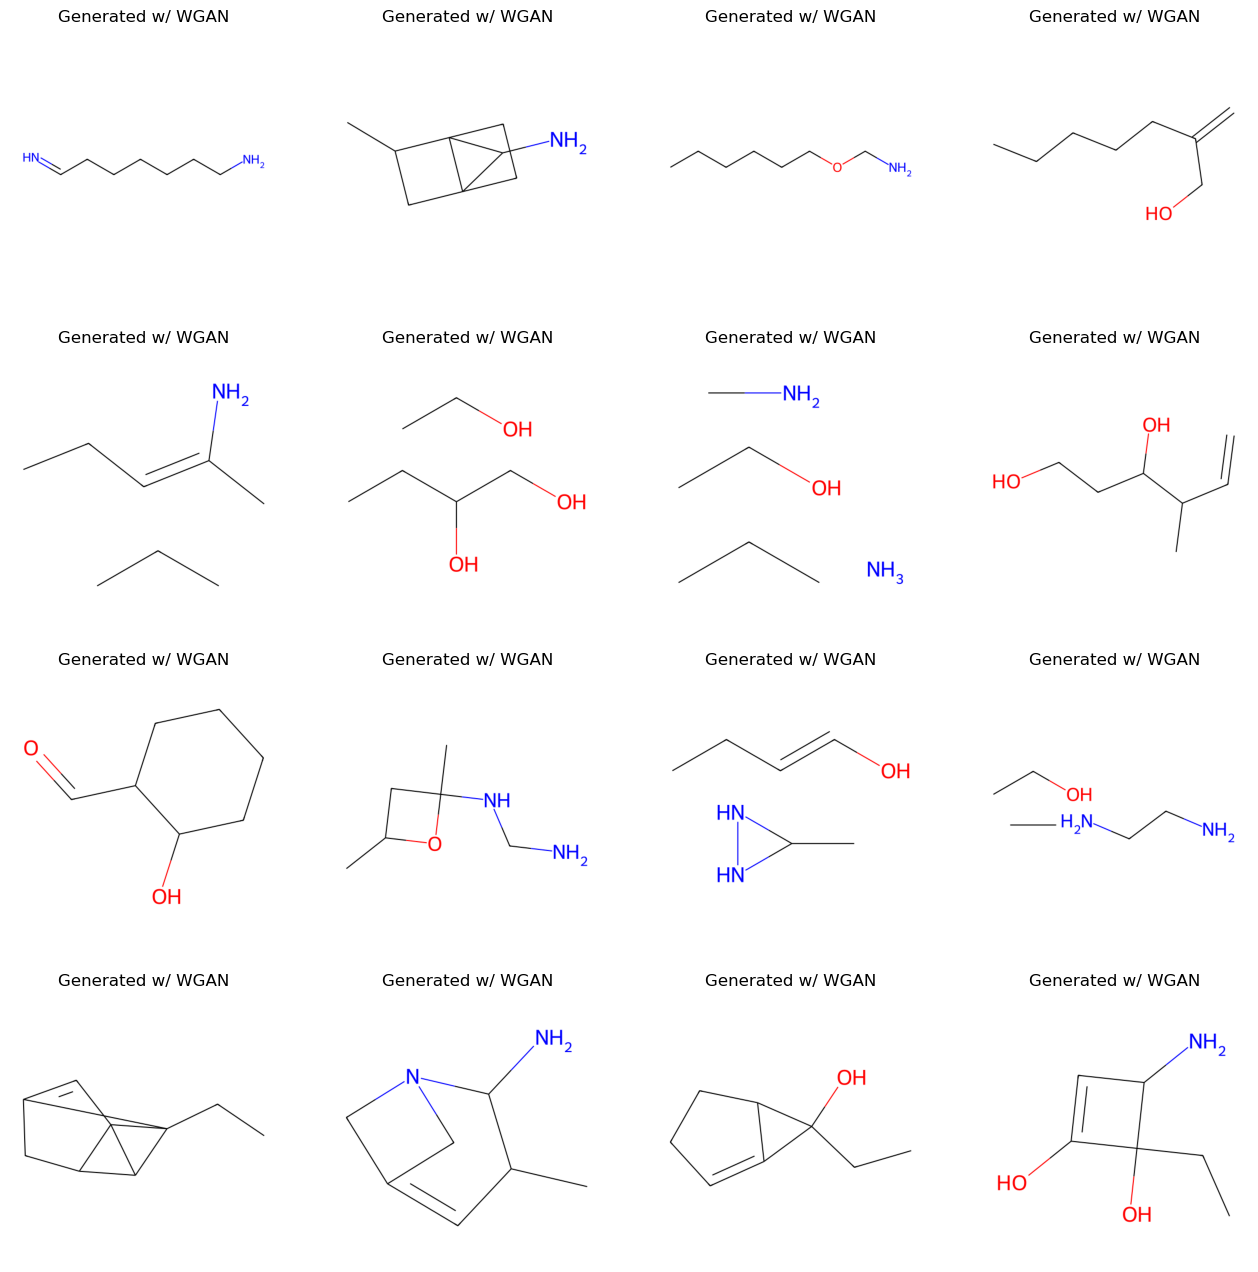

In [11]:
num_valid_mol = len(list_valid_mol)
num_print_mol = 16
list_idx = torch.randperm(num_valid_mol)[:num_print_mol] 
print(list_idx)

from rdkit.Chem import Draw
list_valid_mol_img = [ Draw.MolToImage(Chem.MolFromSmiles(list_valid_mol[idx]),size=(512, 512)) for idx in list_idx ]

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=1,0,1; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=2,0,2; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=3,0,3; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=0,1+0,4; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=1,1+0,5; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=2,1+0,6; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=3,1+0,7; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=0,2+0,8; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=1,2+0,9; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=2,2+0,10; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=3,2+0,11; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=0,3+0,12; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=1,3+0,13; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=2,3+0,14; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
i,j,cpt=3,3+0,15; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ WGAN"); axis[i,j].axis('off')
plt.show() 


## Percentage of unique molecules among the generated molecules

In [12]:
print('num_generated_mol',len(list_mol))
num_unique_mol = 0
for idx,mol in enumerate(list_mol):
    list_tmp = list_mol.copy()
    list_tmp.pop(idx)
    if mol not in list_tmp:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_unique_mol = 100*num_unique_mol/len(list_mol)
print('perc unique molecules among the generated molecules:', str(perc_unique_mol)[:6])


num_generated_mol 1000
num_unique_mol, num_mol: 688 1000
perc unique molecules among the generated molecules: 68.8


## Percentage of novel molecules (not present in the training set)

In [13]:
list_train_mol = [] 
for idx in range(len(train)):
    list_train_mol.append(train[idx].smile) 
print('num_train_mol',len(list_train_mol))
print(list_train_mol[:10])
num_unique_mol = 0
for mol in list_mol:
    if mol not in list_train_mol:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_novel_mol = 100 * num_unique_mol / len(list_mol)
print('perc of novelty:', str(perc_novel_mol)[:6])


num_train_mol 1000
['CC1C(O)C2C(O)CC12', 'N#CCC1=CC(N)=NO1', 'CC1CCC1NCC#N', 'OC1CNC2=C1C=CO2', 'O=CC12NC3C4C1N4C32', 'C1=CC2=C(C=NN2)NC1', 'C1CC23CCC2OCC13', 'C1OCC12NCC21CO1', 'NC1=NC=C(F)C=C1O', 'ON=C1C2CC3C1CC23']
num_unique_mol, num_mol: 1000 1000
perc of novelty: 100.0


## Compare results

| Generative technique    | Validity (%) | Uniqueness (%) | Novelty (%) |
| -------- | ------- | ------- | ------- |
| VAE   | 78.4    | 86.9    |  93.1    |
| WGAN  | 66.5    | 68.8    |  100.0    |

